In [1]:
# Chapter1
# NN構築試行
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score  # モデルの評価を行うための関数
from keras import metrics
# 学習データ読み込み
data_X = pd.read_csv("train.csv")
data = data_X.dropna(how="any")
data.head()

Using TensorFlow backend.


,id,accommodates,amenities,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,cleaning_fee,...,longitude,name,neighbourhood,number_of_reviews,property_type,review_scores_rating,room_type,thumbnail_url,zipcode,y
1,1,2,"{TV,""Cable TV"",Internet,""Wireless Internet"",""A...",1.0,Real Bed,1.0,1.0,strict,DC,t,...,-76.978190,Guest Bedroom in Brookland,Brookland,9,House,100.0,Private room,https://a0.muscache.com/im/pictures/e4d8b51f-6...,20018,42.0
4,4,2,"{TV,Internet,""Wireless Internet"",""Air conditio...",1.0,Real Bed,1.0,1.0,strict,NYC,t,...,-73.974691,Charming 1-bedroom - UWS Manhattan,Upper West Side,5,Apartment,100.0,Entire home/apt,https://a0.muscache.com/im/pictures/92879730/5...,10024,165.0
5,5,2,"{""Wireless Internet"",""Air conditioning"",Kitche...",1.0,Real Bed,1.0,1.0,flexible,NYC,t,...,-74.015729,"Close NYU Langone H, Room A/3min to Subway",Sunset Park,7,House,94.0,Private room,https://a0.muscache.com/im/pictures/dd071463-3...,11220,55.0
6,6,2,"{Internet,""Wireless Internet"",Kitchen,""Free pa...",1.5,Real Bed,1.0,1.0,moderate,NYC,t,...,-73.915965,Cozy Artist Bedroom less than 30 min to Manhattan,Bedford-Stuyvesant,65,House,91.0,Private room,https://a0.muscache.com/im/pictures/79595629/9...,11233,48.0
8,8,2,"{""Wireless Internet"",""Air conditioning"",""Pets ...",1.0,Real Bed,1.0,1.0,strict,SF,t,...,-122.411410,PERFECT Location in North Beach,North Beach,21,Apartment,87.0,Private room,https://a0.muscache.com/im/pictures/b1e47fdc-1...,94133,95.0


In [30]:
from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
# Pandasデータフレームからtf.dataデータセットを作るためのユーティリティメソッド
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('y')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

batch_size = 5 # デモ用として小さなバッチサイズを使用
train_ds = df_to_dataset(data, batch_size=batch_size)

example_batch = next(iter(train_ds))[0]
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())
hoge = data["city"]
hoge

1             DC
4            NYC
5            NYC
6            NYC
8             SF
          ...   
55571         SF
55572         LA
55577    Chicago
55578        NYC
55581         LA
Name: city, Length: 28892, dtype: object

In [31]:
    city = feature_column.categorical_column_with_vocabulary_list(
          'city', ['LA', 'DC', 'NYC', 'SF', 'Chicago', 'Boston'])
    thal_one_hot = feature_column.indicator_column(city)
    demo(thal_one_hot)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

[[0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0. 0.]]


In [69]:
# # Chapter2
# 学習の再現を行うために乱数シードを固定するためのコード
import os
import random as rn
from tensorflow.compat.v1.keras import backend as K

os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(0)
rn.seed(0)

tf.compat.v1.set_random_seed(0)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph())
K.set_session(sess)

#     ds = ds.shuffle(buffer_size=len(dataframe))

pd.set_option("max_columns", None)
# pd.set_option('max_rows', None)

In [100]:
# Chapter3
# データ前処理
def pre_process(input_data_X: pd.DataFrame):
    temp_data = input_data_X.drop(["id","amenities", "bed_type", "cancellation_policy", "city", "description", "first_review", "host_response_rate", "host_since"
                                ,"instant_bookable", "last_review", "name", "neighbourhood", "property_type", "room_type", "thumbnail_url", "zipcode"], axis = 1).replace({"cleaning_fee": {"t":0, "f":1}, "host_has_profile_pic": {"t":0, "f":1}, "host_identity_verified": {"t":0, "f":1}, "instant_bookable": {"t":0, "f":1}})
    # temp_data = input_data_X.drop(["id","amenities", "bed_type", "cancellation_policy", "city", "description", "first_review", "host_response_rate", "host_since"
    #                             ,"instant_bookable", "last_review", "name", "neighbourhood", "property_type", "room_type", "thumbnail_url", "zipcode","accommodates", "bathrooms","bedrooms","beds","cleaning_fee","host_has_profile_pic","host_identity_verified","latitude","longitude","number_of_reviews"], axis = 1).replace({"cleaning_fee": {"t":0, "f":1}, "host_has_profile_pic": {"t":0, "f":1}, "host_identity_verified": {"t":0, "f":1}, "instant_bookable": {"t":0, "f":1}})
    # processed_X = temp_data.replace({"cleaning_fee": {"t":0, "f":1}, "host_has_profile_pic": {"t":0, "f":1}, "host_identity_verified": {"t":0, "f":1}, "instant_bookable": {"t":0, "f":1}})
    processed_X = ((temp_data - temp_data.min()) / (temp_data.max() - temp_data.min()))
    # (x - train_stats['mean']) / train_stats['std']
    return processed_X
train_dataset = data.sample(frac=0.8,random_state=0)
test_dataset = data.drop(train_dataset.index)

train_y = train_dataset["y"]
test_y = test_dataset["y"]
train_X = pre_process(train_dataset.drop(["y"], axis=1))
test_X = pre_process(test_dataset.drop(["y"], axis=1))


In [101]:
# train_stats = train_dataset.describe()
# train_stats.pop("y")
# train_stats = train_stats.transpose()

# def norm(x):
#   return (x - train_stats['mean']) / train_stats['std']
# normed_train_data = norm(train_X)
# normed_test_data = norm(test_X)

In [102]:
test_X.dtypes

accommodates              float64
bathrooms                 float64
bedrooms                  float64
beds                      float64
cleaning_fee              float64
host_has_profile_pic      float64
host_identity_verified    float64
latitude                  float64
longitude                 float64
number_of_reviews         float64
review_scores_rating      float64
dtype: object

In [103]:
import pathlib

import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.metrics import binary_accuracy, Accuracy
from tensorflow.keras.layers import SimpleRNN
import optuna


In [104]:
# hoge = train_dataset.drop(["id","amenities", "bed_type", "cancellation_policy", "city", "description", "first_review", "host_response_rate", "host_since"
#                                 , "last_review", "name", "neighbourhood", "property_type", "room_type", "thumbnail_url", "zipcode"], axis = 1).replace({"cleaning_fee": {"t":0, "f":1}, "host_has_profile_pic": {"t":0, "f":1}, "host_identity_verified": {"t":0, "f":1}, "instant_bookable": {"t":0, "f":1}})
# sns.pairplot(hoge[["y", "accommodates","host_identity_verified","instant_bookable", "number_of_reviews", "review_scores_rating"]], diag_kind="kde")

In [105]:
keras.backend.clear_session()
# Keras以外を利用するのも一つの手段。
model = keras.models.Sequential()
model.add(Dense(units=64, activation=tf.nn.relu, input_shape=[len(train_X.keys())])) 
# model.add(Dropout(0.5))
model.add(Dense(units=64, activation=tf.nn.relu)) 
# model.add(Dropout(0.5))
model.add(Dense(units=1))
model.compile(optimizer = keras.optimizers.RMSprop(lr=0.001),
        loss=keras.losses.mse,
        metrics=["mae", "mse"])

In [106]:
history = model.fit(x = train_X,
    y = train_y,
    batch_size = 8192, # バッチサイズ
    # epochs = 100, # エポック数
    epochs = 700, # エポック数
    validation_split = 0.1, # 検証データの割合
    # callbacks = [es_cb], # 早期終了の設定
    verbose = 1) # 進捗の確認を行うか（0:行わない, 1:行う）

poch 588/700
3/3 [==============================] - 0s 7ms/step - loss: 9010.1963 - mae: 57.5014 - mse: 9010.1963 - val_loss: 8692.3906 - val_mae: 57.4128 - val_mse: 8692.3906
Epoch 589/700
3/3 [==============================] - 0s 8ms/step - loss: 9015.2822 - mae: 57.6729 - mse: 9015.2822 - val_loss: 8721.9199 - val_mae: 57.9226 - val_mse: 8721.9199
Epoch 590/700
3/3 [==============================] - 0s 6ms/step - loss: 9017.2646 - mae: 57.9353 - mse: 9017.2646 - val_loss: 8700.5771 - val_mae: 57.5808 - val_mse: 8700.5771
Epoch 591/700
3/3 [==============================] - 0s 7ms/step - loss: 9011.8467 - mae: 57.8392 - mse: 9011.8467 - val_loss: 8693.9824 - val_mae: 57.4700 - val_mse: 8693.9824
Epoch 592/700
3/3 [==============================] - 0s 7ms/step - loss: 9008.2930 - mae: 57.8821 - mse: 9008.2930 - val_loss: 8657.3955 - val_mae: 56.5375 - val_mse: 8657.3955
Epoch 593/700
3/3 [==============================] - 0s 7ms/step - loss: 9003.5361 - mae: 57.4446 - mse: 9003.5361 -

In [107]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
0,39150.253906,147.280823,39150.253906,38029.218750,143.032852,38029.218750,0
1,39060.628906,146.972916,39060.628906,37960.671875,142.790588,37960.671875,1
2,38990.503906,146.732864,38990.503906,37894.765625,142.559433,37894.765625,2
3,38922.570312,146.501785,38922.570312,37828.273438,142.327881,37828.273438,3
4,38852.109375,146.264420,38852.109375,37755.875000,142.076904,37755.875000,4


In [108]:
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
695,8875.690430,57.177303,8875.690430,8541.387695,57.071529,8541.387695,695
696,8871.143555,57.324940,8871.143555,8500.291992,56.025883,8500.291992,696
697,8865.735352,56.879787,8865.735352,8525.636719,56.746609,8525.636719,697
698,8874.455078,57.355850,8874.455078,8493.898438,55.938347,8493.898438,698
699,8870.605469,57.034882,8870.605469,8490.768555,55.897861,8490.768555,699


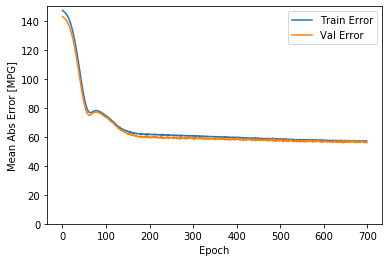

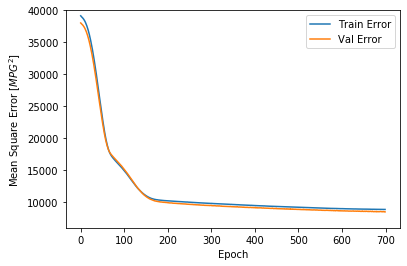

In [109]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,150])
  plt.legend()
  
  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([6000,40000])
  plt.legend()
  plt.show()


plot_history(history)

In [110]:

y_proba = model.predict(test_X)
y_proba

array([[230.64503 ],
       [ 69.31793 ],
       [163.45572 ],
       ...,
       [117.34361 ],
       [ 85.481476],
       [ 99.211975]], dtype=float32)

In [111]:
type(y_pred)
np.savetxt("C:\work\AI\workspace\\10.2_民博サービスの宿泊価格予測\hoge.dat", y_pred)

In [112]:
# 重回帰
# 説明変数の重みを確認
from sklearn import linear_model  # 線形回帰を行うためのモジュール
# 変数の準備
# X = data_oh.drop(["loan_status_ChargedOff", "loan_status_FullyPaid"], axis=1)  # 説明変数の設定
# y = data_oh["loan_status_FullyPaid"]  # 目的変数の設定

# 学習
lr = linear_model.LinearRegression()  # 線形回帰モデルのインスタンスを作成
lr.fit(train_X, train_y)  # 回帰の実行

# 結果の確認
print("回帰係数:")
print(pd.DataFrame({"Name": train_X.columns,
                    "Coefficients": lr.coef_}).sort_values(by='Coefficients'))  # 回帰係数
print("切片:", lr.intercept_)  # 切片
print("決定係数:", lr.score(train_X, train_y))  # 決定係数

回帰係数:
                      Name  Coefficients
3                     beds   -103.959402
9        number_of_reviews    -60.719374
8                longitude    -55.575317
4             cleaning_fee     -9.397498
6   host_identity_verified     -1.250378
5     host_has_profile_pic     61.734586
7                 latitude     71.850006
10    review_scores_rating    106.814630
2                 bedrooms    296.275018
0             accommodates    378.345433
1                bathrooms    382.819277
切片: -101.89500191703084
決定係数: 0.424168208534207


In [136]:
data_X = pd.read_csv("test.csv")

train_X = pre_process(data_X)
y_proba = model.predict(train_X)
y_proba

array([[212.43639  ],
       [111.717    ],
       [ -3.3361354],
       ...,
       [ -3.3361354],
       [ 93.13318  ],
       [ 58.37339  ]], dtype=float32)

In [137]:
np.savetxt("C:\work\AI\workspace\\10.2_民博サービスの宿泊価格予測\\result.dat", y_proba.astype("float"), fmt="%0.10f",)

In [125]:
hoge = y_proba.astype("float")

In [126]:
np.savetxt("C:\work\AI\workspace\\10.2_民博サービスの宿泊価格予測\\hoge.dat", hoge)